## Consolidating our model runs

We have written a model to study whether our data is more likely to be drawn from the `standard` or `rocrit` models presented in van Saders et al. (2019).

We evaluate this using a mixture model, where:

\begin{equation}
p(\theta, P_{s} | D_i) = [P_s \text{KDE}_s(\theta) + (1-P_s)\text{KDE}_{Ro}(\theta)]p(D|\theta)p(P_{s})\, ,
\end{equation}

where $\theta$ are hyperparameters compared directly to measurements of our data in **mass, temperature, log age & log rotation**. $\rm KDE_s$ is a Kernel Density Estimate of the van Saders standard model, and $\rm \rm KDE_{Ro}$ is the same for the critical Rossby model.

If $P_s$ is close to or equal to zero, our set of asteroseismic age and rotation lies in favour of the conditions of the van Saders Rossby model being true, i.e. the weakened magnetic breaking theory.

The equation above functions only for a single star. We want the probability of one model or the other being true given our *entire* dataset, so we multiply all the posterior probabilities for each star together.

In practice, not all stars will inform this result: subgiants and cooler, less evolved stars will either be dominated by other angular momentum changes, or not yet experiencing the effect of weakened magnetic braking. We can study the effects different stellar groups have on the combined posterior estimate of $P_s$ by making the calculation using different stellar groups.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from scipy.stats import gaussian_kde
sns.set_context('poster')
# sns.set_context('paper')
sns.set_palette('colorblind')

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ati = pd.read_csv('../data/atium.csv', index_col=0)
f_ati = pd.read_csv('../data/atium.csv', index_col=0)
ati = ati[ati.eye_flag != 3]

ati.drop(ati[ati.KIC == 6603624].index, inplace=True)
ati.drop(ati[ati.KIC == 8760414].index, inplace=True)
ati.drop(ati[ati.KIC == 8938364].index, inplace=True)
print(f'Working with {len(ati)} stars')

Working with 91 stars


Reading in the posterior samples

In [3]:
%%time
# d = '/home/oliver/PhD/mnt/RDS/malatium/models_upgrade/'
d = '/Users/Oliver/Desktop/Models/'
post_pa = []
i = 0
for idx, kic in list(zip(ati.index.values, ati.KIC.values)):
    try:
        post_pa.append(pd.read_csv(f"{d}{int(kic)}_samples.csv")['P_A'])
        i += 1
    except FileNotFoundError:
        print(f'File not found for index {idx}')
        print(kic)
        try:
            ati.drop(index=idx, inplace=True)
        except KeyError:
            print('Unique KIC 8760414 duplicate exclusion problem')
        continue               

File not found for index 19
7106245
File not found for index 75
6278762
CPU times: user 12.6 s, sys: 3.69 s, total: 16.3 s
Wall time: 17.6 s


In an ideal world, we would multiply the posterior functions for every star. However we have samples instead of functions. We overcome this by multiplying the probability value in each of 100 bins for all stars, approximating the shape of a combined posterior function.

In [4]:
bins = np.linspace(0, 1, 101)
hists = np.array([np.histogram(n, bins=bins, density=True)[0] for n in post_pa])

### The overall result:

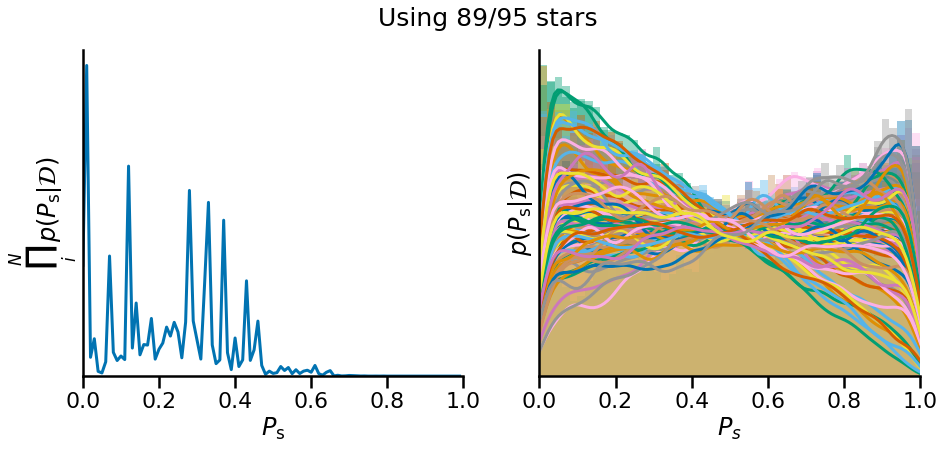

In [5]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], posterior)
# ax[0].set_xlabel('Probability Jen is wrong')
ax[0].set_xlabel(r'$P_{\rm s}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in post_pa:
    sns.distplot(n[np.isfinite(n)], ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(post_pa)}/95 stars', fontsize=25)

plt.show()

### A check on convergence 

While we appear to have decent convergence on all parameters, there are some with low numbers of effective samples, or Rhat values that are high enough to raise eyebrows a little. We'll run the same checks, but with those removed.

We'll remove all stars with:
- Any of the core 4 parameters outside the KDE range (as in the example above)
- $n_{\rm eff} < 1000$ on splitting.
- $\hat{R} > 1.1$ on a rotational parameter.

In [6]:
c2 = ati.copy(deep=True)
sel = (c2.neff_split > 1000) & (c2.rhat_flag != 'rhat_1')
hists_sel_cov = hists[sel]
sg = c2[sel]['hrclass'] == 'SG'
ms = c2[sel]['hrclass'] == 'MS'
h = c2[sel]['hrclass'] == 'H'
print(f'Number of stars: {len(c2[sel])}/89')
print(f'We have {len(c2[sel][sg])} Sub-Giant stars.')
print(f'We have {len(c2[sel][h])} Hot stars.')
print(f'We have {len(c2[sel][ms])} Main-Sequence stars.')

Number of stars: 73/89
We have 4 Sub-Giant stars.
We have 22 Hot stars.
We have 47 Main-Sequence stars.


When considering all stars:

In [7]:
p0 = np.prod(hists_sel_cov[:,:50],axis=0)
p1 = np.prod(hists_sel_cov[:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

307.79171068608935
5.013249153244323
98.40%


When considering MS only:

In [9]:
p0 = np.prod(hists_sel_cov[ms][:,:50],axis=0)
p1 = np.prod(hists_sel_cov[ms][:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

621.3788058743035
5.342226473686045
99.15%


When considering the full 89 stars

In [10]:
p0 = np.prod(hists[:,:50],axis=0)
p1 = np.prod(hists[:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

177.7298330147046
5.735163031768489
96.87%


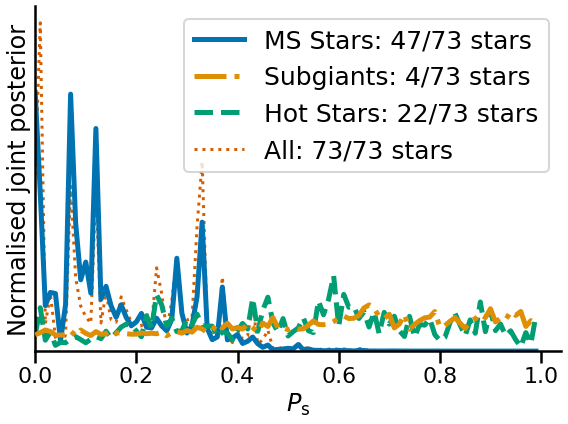

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
y = np.prod(hists_sel_cov[ms], axis=0)
ax.plot(bins[:-1], y / np.mean(y), lw=5, zorder=1,
        label=fr'MS Stars: {len(hists_sel_cov[ms])}/{len(c2[sel])} stars')

y = np.prod(hists_sel_cov[sg], axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls='-.', zorder=3, lw=5,
        label=fr'Subgiants: {len(hists_sel_cov[sg])}/{len(c2[sel])} stars')

y =  np.prod(hists_sel_cov[h], axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls='--', zorder=2, lw=5,
        label=fr'Hot Stars: {len(hists_sel_cov[h])}/{len(c2[sel])} stars')
                       
y = np.prod(hists_sel_cov, axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls=':', zorder=0,
        label=fr'All: {len(hists_sel_cov)}/{len(c2[sel])} stars')


ax.set_ylabel(r'Normalised joint posterior')
ax.set_xlabel(r'$P_{\rm s}$')
ax.set_yticks([])
# ax.set_yscale('log')
ax.set_ylim(0)
ax.set_xlim(0)
ax.legend(loc='upper right', fontsize=25)

sns.despine()
fig.tight_layout()
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/type_comparison.png', bbox_inches='tight', dpi=300)
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/type_comparison.pdf', bbox_inches='tight', rasterized=True)
plt.show()

In [12]:
fsel = ati['KIC'].isin(c2[sel]['KIC'])
f_post_pa = np.array(post_pa)[fsel]

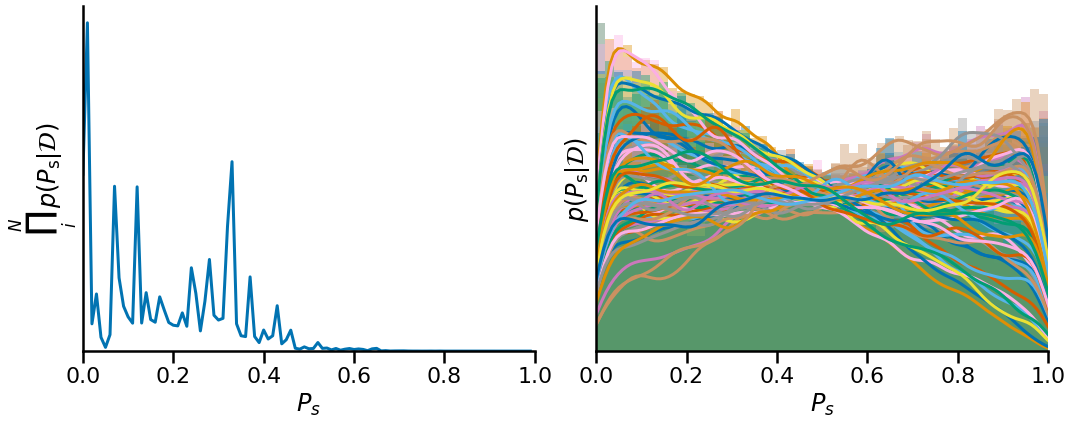

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov, axis=0))
# ax[0].set_xlabel('Probability vS+16 is wrong')
ax[0].set_xlabel(r'$P_s$')
# ax[0].set_xlabel(r'$P_{\rm s}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
# ax[1].set_ylim(0)
ax[1].get_yaxis().set_ticks([])
sns.despine()

# fig.suptitle(fr'Using {len(hists_sel_cov)}/95 stars', fontsize=25)
fig.tight_layout()
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/modelresults.pdf', bbox_inches='tight',rasterized=True)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/modelresults.pdf', bbox_inches='tight',rasterized=True)
plt.show()

## Finally, let's plot the stars in this final example

In [14]:
standard = pd.read_hdf('../data/jvs_models/standard_population.h5', key='sample', mode='r')
standard.rename(columns={'period':'P',
                         'age':'Age','mass':'M'}, inplace=True)
standard.head(1)

,M,Teff,logg,Age,log(L/Lsun),kepmag,P,[Fe/H],sdss_g,sdss_r,sdss_i,sdss_z,2mass_j,2mass_h,2mass_k,distmod,av
0,0.90424,5674.121798,4.54636,2.34408,-0.183266,13.179899,16.514088,-0.25,13.608602,13.11637,12.989363,12.9559,12.057497,11.71793,11.673961,8.0,0.023


In [15]:
rocrit = pd.read_hdf('../data/jvs_models/rocrit_population.h5', key='sample', mode='r')
rocrit.rename(columns={'period':'P',
                         'age':'Age','mass':'M'}, inplace=True)
rocrit.head(1)

,M,Teff,logg,Age,log(L/Lsun),kepmag,P,[Fe/H],sdss_g,sdss_r,sdss_i,sdss_z,2mass_j,2mass_h,2mass_k,distmod,av
0,1.61144,5058.112357,3.440028,1.877246,0.974361,11.350579,45.489845,-0.11,11.991957,11.279396,11.073495,10.975381,9.958406,9.495029,9.427129,9.0,0.028


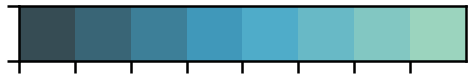

In [16]:
from matplotlib.colors import ListedColormap
snsmap = sns.color_palette('GnBu_d',8)
cmap = ListedColormap(snsmap.as_hex())
sns.palplot(snsmap)

In [17]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'

### Flagging stars for various points of interest:

In [18]:
f_ati = f_ati[f_ati.eye_flag != 3]

In [19]:
fsel = f_ati['KIC'].isin(c2[sel]['KIC'])
fin = f_ati[fsel]

Ps = np.median(f_post_pa, axis=1)
exc = f_ati.loc[~f_ati['KIC'].isin(fin.KIC)]
feh = fin.loc[np.abs(fin.feh.values) > 0.4]
excfeh = exc.loc[np.abs(exc.feh.values) > 0.4]

In [20]:
feh

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
27,7970740,5309,12.9817,173.541,77,0.060,0.10,21.2,-0.54,1.9963,...,0.023260,8.981911,39.171862,6.709077,0.074730,0.859749,0.083975,NaN,0,0.000922
35,8694723,6246,4.6932,75.112,77,0.019,0.10,3.7,-0.42,0.5110,...,0.027180,0.642725,7.171496,0.805241,0.335872,6.217464,0.317210,NaN,0,0.001322
48,9965715,5860,2.9206,97.236,180,0.041,0.18,9.2,-0.44,0.7506,...,0.032926,0.250115,5.624670,0.284942,0.288468,10.131403,0.277007,NaN,0,0.001851


In [21]:
ms = (fin.hrclass == 'MS').values
h = (fin.hrclass == 'H').values
sg = (fin.hrclass == 'SG').values

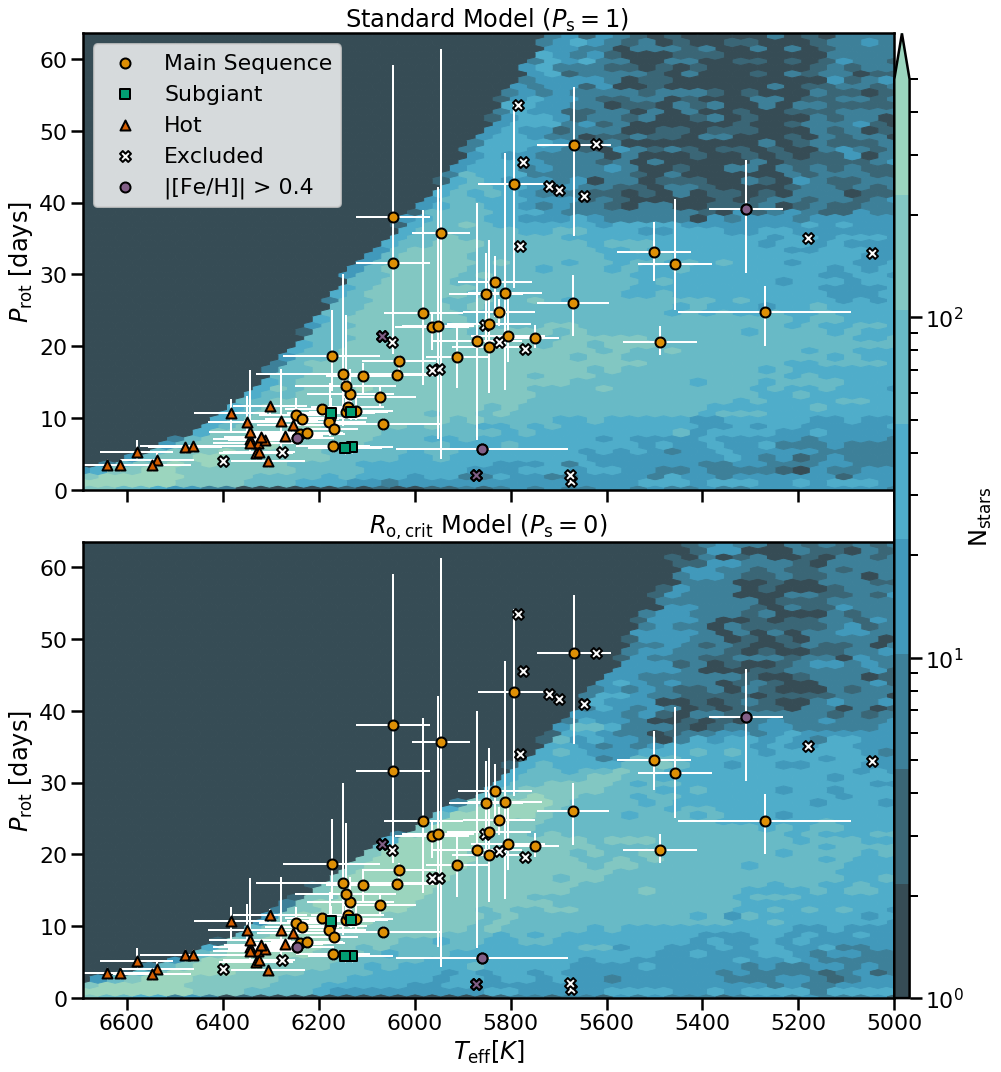

In [22]:
fig, axes = plt.subplots(2,1, figsize=(15,15), sharex=True)
ax = axes[0]
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log', vmin=1, vmax=500)
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=100,zorder=3, ec='k', lw='2', label='Main Sequence')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=100,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=100,zorder=3, ec='k', lw='2', label='Hot')

# Excluded
ax.scatter(exc.Teff, exc.P, marker='X', s=120,zorder=2, ec='k', c='w', lw=2, label='Excluded')
# FeH
ax.scatter(excfeh.Teff, excfeh.P, marker='X', s=120,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2)
ax.scatter(feh.Teff, feh.P, marker='o', s=100,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2, label='|[Fe/H]| > 0.4')
ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, ati.P.max() + 10)
ax.set_xlim(ati.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
# ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper left')

ax = axes[1]
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log', vmin=1, vmax=500)
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=100,zorder=3, ec='k', lw='2', label='Main Sequence')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=100,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=100,zorder=3, ec='k', lw='2', label='Hot')

ax.scatter(exc.Teff, exc.P, marker='X', s=120,zorder=2, ec='k', c='w', lw=2, label='Excluded')
ax.scatter(excfeh.Teff, excfeh.P, marker='X', s=120,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2)
ax.scatter(feh.Teff, feh.P, marker='o', s=100,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2, label='|[Fe/H]| > 0.4')

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, ati.P.max() + 10)
ax.set_xlim(ati.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
ax.set_xlabel(r'$T_{\rm eff} [K]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
# ax.legend(loc='upper left')

fig.tight_layout()
fig.colorbar(c, ax=axes.ravel(),label=r'$\rm{N_{\rm stars}}$', pad=0, aspect=60, extend='max')
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.png', bbox_inches='tight', dpi=300)
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.pdf', bbox_inches='tight', rasterized=True)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.png', bbox_inches='tight', dpi=300)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.pdf', bbox_inches='tight', rasterized=True)
plt.show()

### Let's plot the posterior distributions on $P_s$ for stars outside the [Fe/H] range

In [23]:
fin.shape

(73, 62)

In [24]:
hists_sel_cov.shape

(73, 100)

In [25]:
feh = fin[np.abs(fin.feh) > 0.4]
feh_pa = np.array(f_post_pa)[np.abs(fin.feh) > 0.4]
mass = fin[fin.modmass >= 1.3]
mass_pa = np.array(f_post_pa)[fin.modmass >= 1.3]

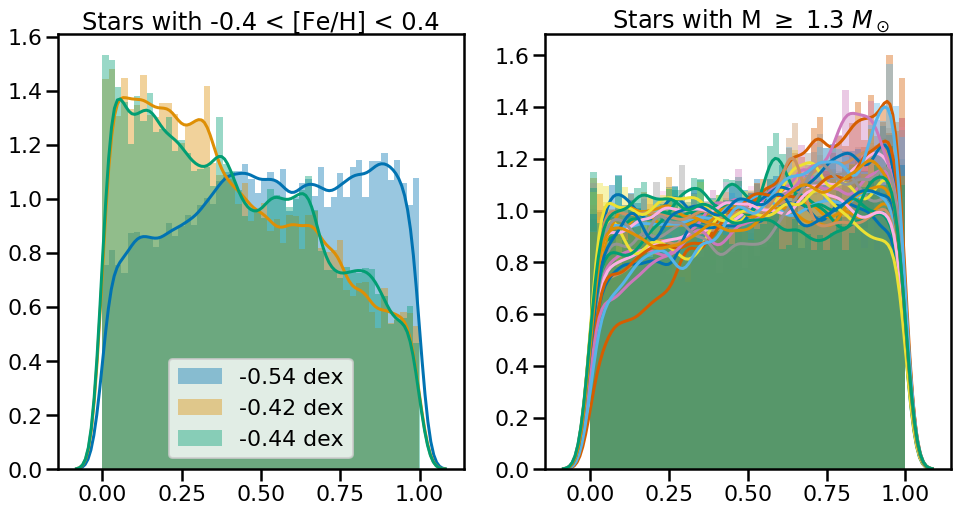

In [26]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(16,8))
for idx, pa in enumerate(feh_pa):
    sns.distplot(pa, label=f'{feh.feh.values[idx]} dex', ax=ax)
for idx, pa in enumerate(mass_pa):
    sns.distplot(pa, ax=ax2)    
ax.legend(loc='lower center')
ax.set_title(r'Stars with -0.4 < [Fe/H] < 0.4')
ax2.set_title(r' Stars with M $\geq$ 1.3 $M_\odot$')
plt.show()

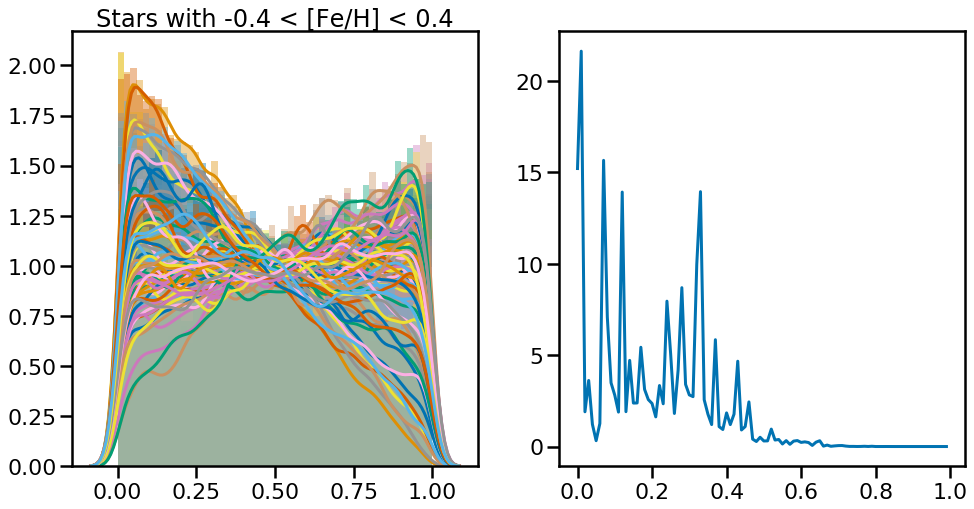

In [27]:
feh = fin[np.abs(fin.feh) < 0.4]
feh_pa = np.array(f_post_pa)[np.abs(fin.feh) < 0.4]
fig, (ax, ax2) = plt.subplots(1,2, figsize=(16,8))
for idx, pa in enumerate(feh_pa):
    sns.distplot(pa, label=f'{feh.feh.values[idx]} dex', ax=ax)
ax2.plot(bins[:-1], np.prod(hists_sel_cov[np.abs(fin.feh) < 0.4], axis=0))
ax.set_title(r'Stars with -0.4 < [Fe/H] < 0.4')
plt.show()

In [28]:
p0 = np.prod(hists_sel_cov[np.abs(fin.feh < 0.40)][:,:50],axis=0)
p1 = np.prod(hists_sel_cov[np.abs(fin.feh < 0.40)][:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

307.79171068608935
5.013249153244323
98.40%


## Check the posterior excluding stars with mass uncertainties below 0.02 Msol

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


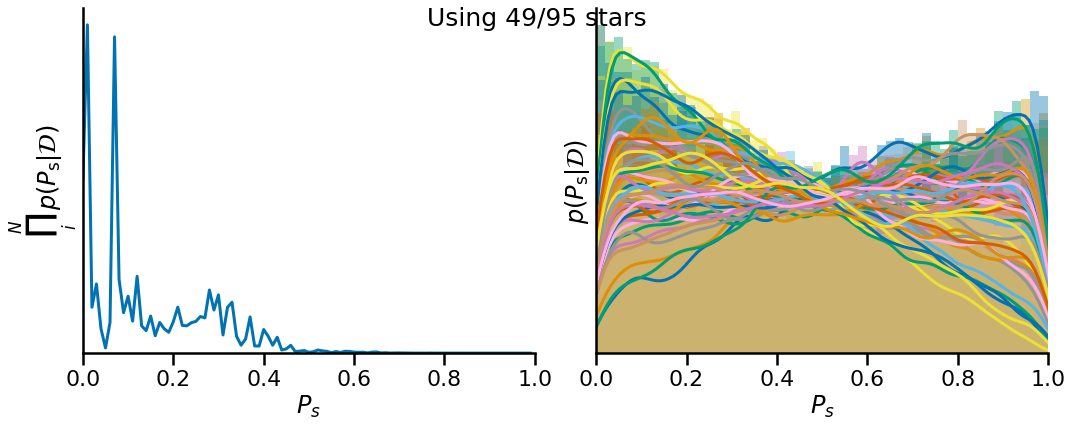

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


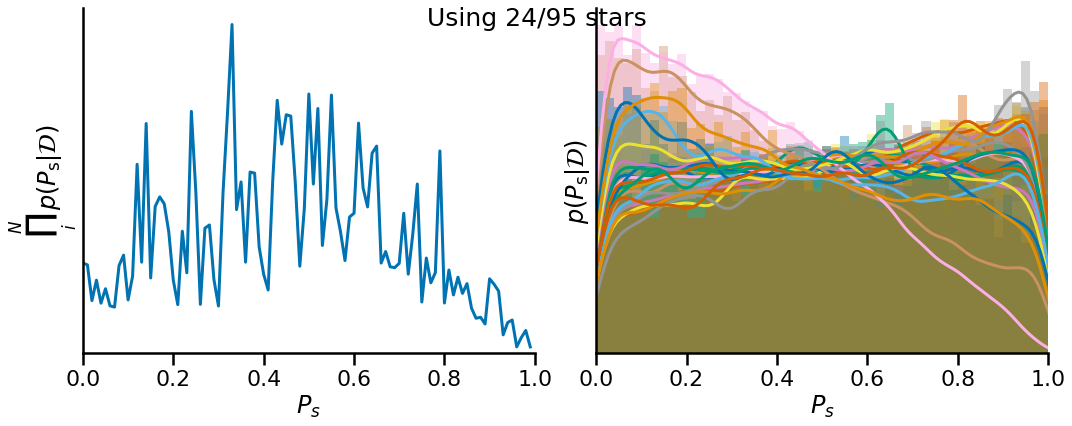

In [29]:
fin = ati[fsel]
sel = (fin.upmodmass > 0.02) & (fin.lomodmass > 0.02)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa[sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(hists_sel_cov[sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()
fin = ati[fsel]
sel = (fin.upmodmass > 0.02) & (fin.lomodmass > 0.02)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[~sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa[~sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(hists_sel_cov[~sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

In [30]:
p0 = np.prod(hists_sel_cov[:,:50],axis=0)
p1 = np.prod(hists_sel_cov[:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

307.79171068608935
5.013249153244323
98.40%


In [31]:
p0 = np.prod(hists_sel_cov[sel][:,:50],axis=0)
p1 = np.prod(hists_sel_cov[sel][:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

487.45823671087044
4.9834594443457565
98.99%


## I want to exclude stars that were in the JvS+19 sample

In [32]:
fin = ati[fsel]
mss = fin[fin.hrclass == 'MS']
ms_post_pa = f_post_pa[fin.hrclass == 'MS']
ms_hists = hists_sel_cov[fin.hrclass == 'MS']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [33]:
excl = [12069424,
12069449,
3427720,
3656476,
5184732,
6116048,
6196457,
6521045,
7680114,
7871531,
8006161,
8349582,
9098294,
9139151,
9955598,
10454113,
10586004,
10644253,
10963065,
11244118,
11401755]

In [34]:
sel = ~mss.KIC.isin(excl)

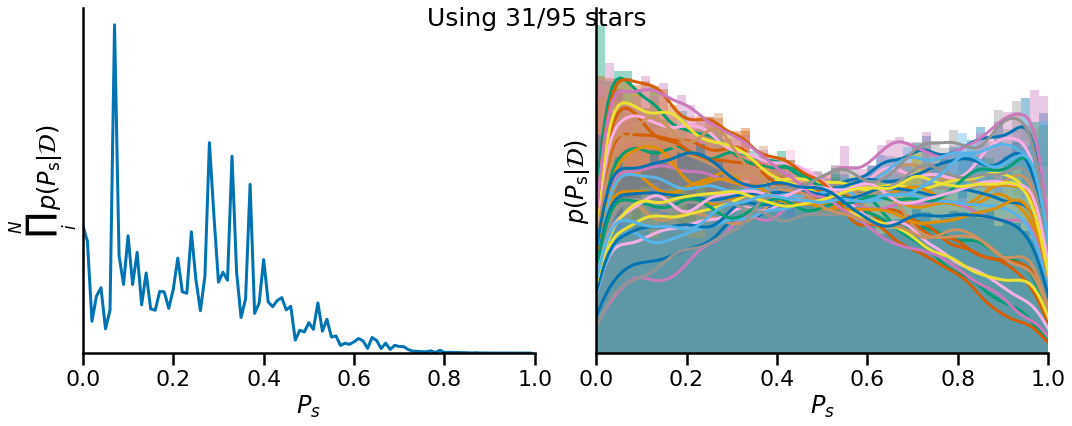

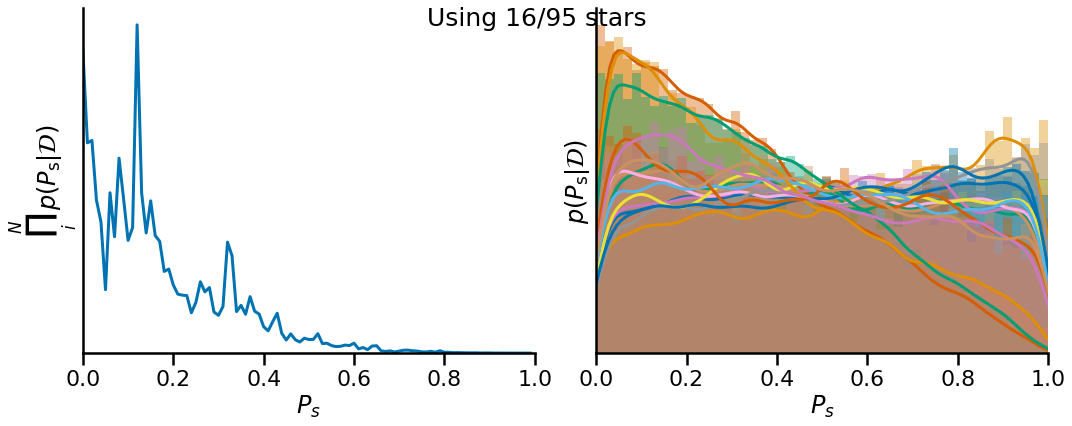

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(ms_hists[sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in ms_post_pa[sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(ms_hists[sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(ms_hists[~sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in ms_post_pa[~sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(ms_hists[~sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

In [36]:
p0 = np.prod(ms_hists[sel][:,:50],axis=0)
p1 = np.prod(ms_hists[sel][:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

110.98751937430441
10.041753569243175
91.70%


In [37]:
p0 = np.prod(ms_hists[~sel][:,:50],axis=0)
p1 = np.prod(ms_hists[~sel][:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

253.05145882063925
9.799853715753834
96.27%


In [38]:
p0 = np.prod(ms_hists[:,:50],axis=0)
p1 = np.prod(ms_hists[:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

621.3788058743035
5.342226473686045
99.15%


## Check against Lorenzo-Oliveira stars

In [38]:
fin = ati[fsel]
print(len(fin))

71


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [39]:
excl = [6541920,
        10130039,
       12404954,
       7202957]
sel = fin.KIC.isin(excl)

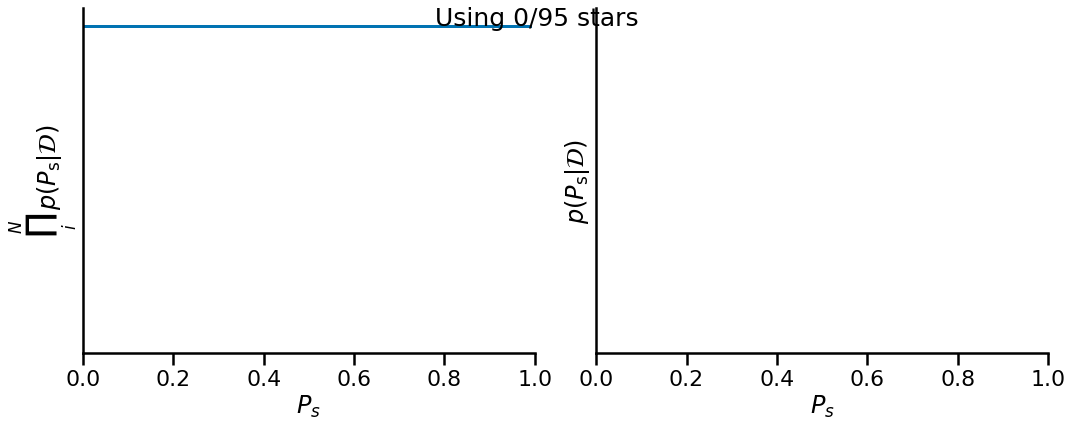

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa[sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(hists_sel_cov[sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

### Let's look at the median values for $P_s$ for our stars of interest

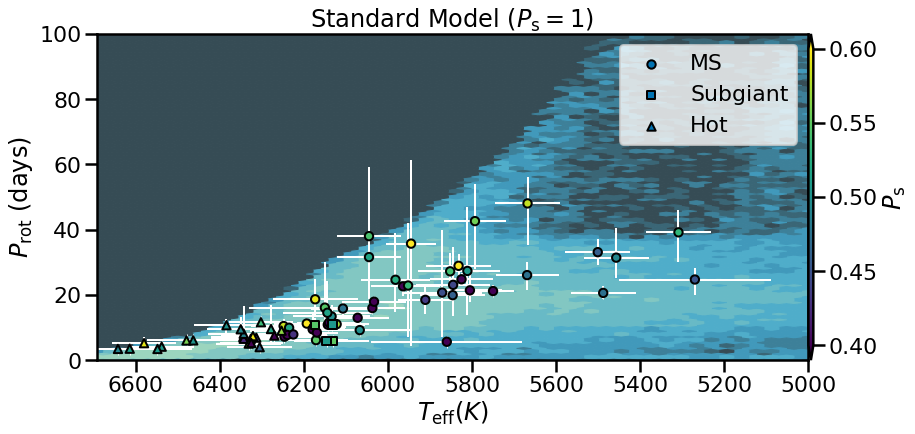

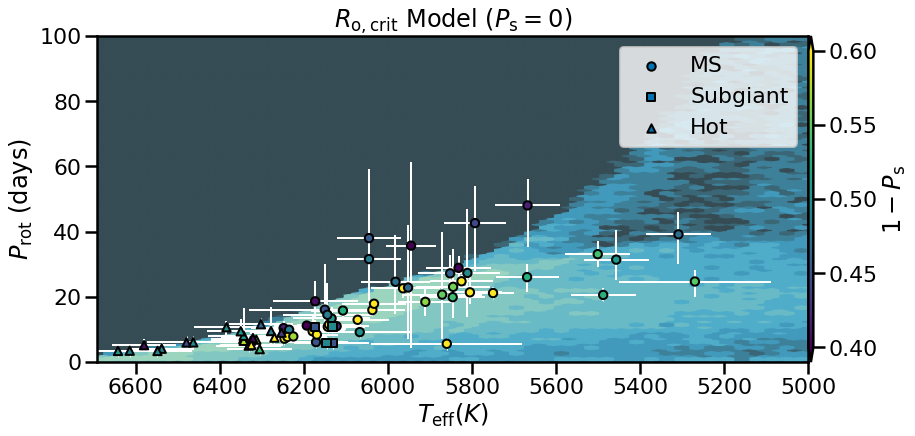

In [41]:
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
c= ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=70, zorder=3, ec='k', c=Ps[ms], lw=2, label='MS',
          vmin=0.4 , vmax=0.6)
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k', c=Ps[sg],  lw=2, label='Subgiant',
          vmin=0.4 , vmax=0.6)
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=70,zorder=3, ec='k', c=Ps[h],  lw=2, label='Hot',
          vmin=0.4 , vmax=0.6)

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(fin.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper right')
# fig.colorbar(c, label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)
fig.colorbar(c, label=r'$P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
c = ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=70,zorder=3, ec='k',  c=(1.-Ps[ms]), lw=2, 
               vmin = 0.4, vmax=0.6, label='MS')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k',  c=(1.-Ps[sg]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=70,zorder=3, ec='k',  c=(1.-Ps[h]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Hot')

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(fin.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper right')
fig.colorbar(c, label=r'$1 - P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()

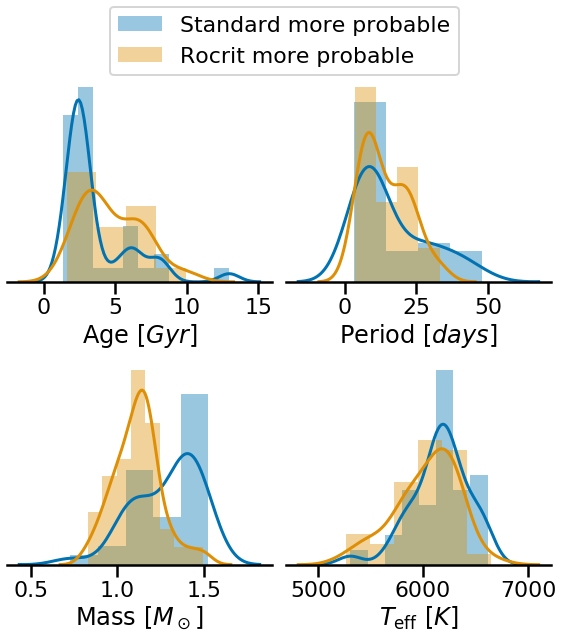

In [40]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
ax = axes.ravel()
sns.distplot(fin[Ps > 0.5].age, ax=ax[0], label='Standard more probable')
sns.distplot(fin[Ps < 0.5].age, ax=ax[0], label='Rocrit more probable')
ax[0].set_xlabel(r'Age [$Gyr$]')

sns.distplot(fin[Ps > 0.5].P, ax=ax[1])
sns.distplot(fin[Ps < 0.5].P, ax=ax[1])
ax[1].set_xlabel(r'Period [$days$]')

sns.distplot(fin[Ps > 0.5].modmass, ax=ax[2])
sns.distplot(fin[Ps < 0.5].modmass, ax=ax[2])
ax[2].set_xlabel(r'Mass [$M_\odot$]')

sns.distplot(fin[Ps > 0.5].Teff, ax=ax[3])
sns.distplot(fin[Ps < 0.5].Teff, ax=ax[3])
ax[3].set_xlabel(r'$T_{\rm eff}$ [$K$]')


sns.despine()
for a in ax:
    a.spines['left'].set_visible(False)
    a.set_yticks([])
fig.tight_layout()
ax[0].legend(bbox_to_anchor=(0.75,0.4,1,1))
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/sample_posterior_comp.png', dpi=300)
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/sample_posterior_comp.pdf', rasterized=True)
plt.show()

In [ ]:
sys.exit()

And in other parameter spaces:

In [ ]:
sg = fin['hrclass'] == 'SG'
ms = fin['hrclass'] == 'MS'
h = fin['hrclass'] == 'H'

In [ ]:
## Age v P
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Age, rocrit.P, cmap=cmap, bins='log')
c = ax.scatter(fin.age[ms], fin.P[ms], marker='o', s=70,zorder=3, ec='k',  c=(1.-Ps[ms]), lw=2, 
               vmin = 0.4, vmax=0.6, label='MS')
ax.scatter(fin.age[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k',  c=(1.-Ps[sg]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Subgiant')
ax.scatter(fin.age[h], fin.P[h], marker='^', s=70,zorder=3, ec='k',  c=(1.-Ps[h]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Hot')

ax.errorbar(fin.age, fin.P, c='w', lw=2, xerr=[fin.loage, fin.upage], yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$\tau\ [\rm{Gyr}]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper left')

ax.set_xlim(rocrit.Age.min(), rocrit.Age.max())
ax.set_ylim(0, 60)
fig.colorbar(c, label=r'$1 - P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()

## Mass v P
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.M, rocrit.P, cmap=cmap, bins='log')
c = ax.scatter(fin.modmass[ms], fin.P[ms], marker='o', s=70,zorder=3, ec='k',  c=(1.-Ps[ms]), lw=2, 
               vmin = 0.4, vmax=0.6, label='MS')
ax.scatter(fin.modmass[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k',  c=(1.-Ps[sg]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Subgiant')
ax.scatter(fin.modmass[h], fin.P[h], marker='^', s=70,zorder=3, ec='k',  c=(1.-Ps[h]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Hot')

ax.errorbar(fin.modmass, fin.P, c='w', lw=2,
            xerr=[fin.lomodmass, fin.upmodmass], yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper left')

ax.set_xlim(1.6, 0.8)
ax.set_ylim(0, 60)
fig.colorbar(c, label=r'$1 - P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()